## Telecom Churn Case Study
With 21 predictor variables we need to predict whether a particular customer will switch to another telecom provider or not. In telecom terminology, this is referred to as churning and not churning, respectively.

### Step 1: Importing and Merging Data

In [352]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

In [353]:
# Importing Pandas and NumPy
import pandas as pd, numpy as np
import copy
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score

### Custom Methods

#### 'get_evaluation_metrics' method - Calculate % of False Negative rather than actual no.

In [476]:
def get_evaluation_metrics(database, actual_y_column_name, predicted_y_column_name, Print=True):
    
    # Confusion matrix 
    confusion_matrix_table = metrics.confusion_matrix(database[actual_y_column_name], database[predicted_y_column_name])
    if Print:
        print('Confusion Matrix: \n', confusion_matrix_table)
    #confusion_matrix = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted)
    
    # Precision Score
    precision = precision_score(database[actual_y_column_name], database[predicted_y_column_name])
    if Print:
        print('Precision Score: ', precision)
    #precision_score = precision_score(y_train_pred_final.Churn, y_train_pred_final.predicted)
    
    # Recall Score
    recall = recall_score(database[actual_y_column_name], database[predicted_y_column_name])
    if Print:
        print('Recall Score: ', recall)
    #recall_score = recall_score(y_train_pred_final.Churn, y_train_pred_final.final_predicted)
    
    # Extract the values from the confusion matrix
    TN, FP, FN, TP = confusion_matrix_table.ravel()

    # Calculate specificity
    specificity = TN / (TN + FP)
    if Print:
        print('Specificity: ', specificity)
    
    # False Negative
    if Print:
        FN_perc = (FN/len(database))*100
        print(f'False Negative %: {FN_perc} ({FN})')
    
    # Accuracy Score
    accuracy = metrics.accuracy_score(database[actual_y_column_name], database[predicted_y_column_name])
    if Print:
        print('Accuracy: ', accuracy)
    
    return confusion_matrix_table, precision, recall, specificity, FN_perc, accuracy

In [355]:
# Importing all datasets
churn_data = pd.read_csv("churn_data.csv")
churn_data.head()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [356]:
customer_data = pd.read_csv("customer_data.csv")
customer_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [357]:
internet_data = pd.read_csv("internet_data.csv")
internet_data.head()

,customerID,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,No phone service,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,No,Fiber optic,No,No,No,No,No,No


#### Combining all data files into one consolidated dataframe

In [358]:
# Merging on 'customerID'
df_1 = pd.merge(churn_data, customer_data, how='inner', on='customerID')

In [359]:
# Final dataframe with all predictor variables
telecom = pd.merge(df_1, internet_data, how='inner', on='customerID')

### Step 2: Inspecting the Dataframe

In [360]:
# Let's see the head of our master dataset
telecom.head()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,...,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Female,...,Yes,No,No phone service,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No,Male,...,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Male,...,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Male,...,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Female,...,No,No,No,Fiber optic,No,No,No,No,No,No


In [361]:
# Let's check the dimensions of the dataframe
telecom.shape

(7043, 21)

In [362]:
# let's look at the statistical aspects of the dataframe
telecom.describe()

,tenure,MonthlyCharges,SeniorCitizen
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,0.162147
std,24.559481,30.090047,0.368612
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,0.000000
50%,29.000000,70.350000,0.000000
75%,55.000000,89.850000,0.000000
max,72.000000,118.750000,1.000000


In [363]:
# Let's see the type of each column
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   tenure            7043 non-null   int64  
 2   PhoneService      7043 non-null   object 
 3   Contract          7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   Churn             7043 non-null   object 
 9   gender            7043 non-null   object 
 10  SeniorCitizen     7043 non-null   int64  
 11  Partner           7043 non-null   object 
 12  Dependents        7043 non-null   object 
 13  MultipleLines     7043 non-null   object 
 14  InternetService   7043 non-null   object 
 15  OnlineSecurity    7043 non-null   object 
 16  OnlineBackup      7043 non-null   object 


### Step 3: Data Preparation

#### Inspecting Value Count of Each Column

In [364]:
for col in telecom.columns:
    print('--'*20)
    print(f'Value Count of {col} column')
    print(telecom[col].value_counts())

----------------------------------------
Value Count of customerID column
7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: customerID, Length: 7043, dtype: int64
----------------------------------------
Value Count of tenure column
1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: tenure, Length: 73, dtype: int64
----------------------------------------
Value Count of PhoneService column
Yes    6361
No      682
Name: PhoneService, dtype: int64
----------------------------------------
Value Count of Contract column
Month-to-month    3875
Two year          1695
One year          1473
Name: Contract, dtype: int64
----------------------------------------
Value Count of PaperlessBilling column
Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64
----------------------------------------
V

##### Findings

1. We can see that there are various columns which have only 2 unique values. Let's look at them separately.
2. We can notice that 'TotalCharges' has 11 values as empty string. As these are less than 1%, therefore, let's remove them. Also, these values should be float type but it is stored as a string. Let's change them to float.
3. Need to create dummy variables for categorical columns.
4. 'customerID' is not of any use. Let's drop it.

#### Dropping 'customerID'

In [365]:
telecom.drop('customerID', inplace=True, axis=1)

#### Cleaning Up & Converting 'TotalCharges'

In [366]:
telecom = telecom[~(telecom['TotalCharges'] == ' ')]
telecom

,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Female,0,Yes,No,No phone service,DSL,No,Yes,No,No,No,No
1,34,Yes,One year,No,Mailed check,56.95,1889.5,No,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
2,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
3,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Male,0,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,24,Yes,One year,Yes,Mailed check,84.80,1990.5,No,Male,0,Yes,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes
7039,72,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No,Female,0,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes
7040,11,No,Month-to-month,Yes,Electronic check,29.60,346.45,No,Female,0,Yes,Yes,No phone service,DSL,Yes,No,No,No,No,No
7041,4,Yes,Month-to-month,Yes,Mailed check,74.40,306.6,Yes,Male,1,Yes,No,Yes,Fiber optic,No,No,No,No,No,No


In [367]:
telecom['TotalCharges'] = telecom['TotalCharges'].astype(float, errors="ignore")

#### Inspecting columns with only 2 unique values

In [368]:
# Extracting columns with only 2 unique values
columns_having_2_unique_values = []
for col in telecom.columns:
    if telecom[col].nunique() == 2:
        columns_having_2_unique_values.append(col)
        
print('Columns having only 2 unique values are: ',columns_having_2_unique_values)        

Columns having only 2 unique values are:  ['PhoneService', 'PaperlessBilling', 'Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents']


In [369]:
for col in columns_having_2_unique_values:
    print('--'*20)
    print(f'Value Count of {col} column')
    print(telecom[col].value_counts())

----------------------------------------
Value Count of PhoneService column
Yes    6352
No      680
Name: PhoneService, dtype: int64
----------------------------------------
Value Count of PaperlessBilling column
Yes    4168
No     2864
Name: PaperlessBilling, dtype: int64
----------------------------------------
Value Count of Churn column
No     5163
Yes    1869
Name: Churn, dtype: int64
----------------------------------------
Value Count of gender column
Male      3549
Female    3483
Name: gender, dtype: int64
----------------------------------------
Value Count of SeniorCitizen column
0    5890
1    1142
Name: SeniorCitizen, dtype: int64
----------------------------------------
Value Count of Partner column
No     3639
Yes    3393
Name: Partner, dtype: int64
----------------------------------------
Value Count of Dependents column
No     4933
Yes    2099
Name: Dependents, dtype: int64


#### Converting some binary variables (Yes/No) to 0/1

In [370]:
# List of variables to map

varlist =  ['PhoneService', 'PaperlessBilling', 'Churn', 'Partner', 'Dependents']

# Defining the map function
def binary_map(x):
    return x.map({'Yes': 1, "No": 0})

# Applying the function to the housing list
telecom[varlist] = telecom[varlist].apply(binary_map)

In [371]:
telecom.head()

,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,1,0,Month-to-month,1,Electronic check,29.85,29.85,0,Female,0,1,0,No phone service,DSL,No,Yes,No,No,No,No
1,34,1,One year,0,Mailed check,56.95,1889.50,0,Male,0,0,0,No,DSL,Yes,No,Yes,No,No,No
2,2,1,Month-to-month,1,Mailed check,53.85,108.15,1,Male,0,0,0,No,DSL,Yes,Yes,No,No,No,No
3,45,0,One year,0,Bank transfer (automatic),42.30,1840.75,0,Male,0,0,0,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,2,1,Month-to-month,1,Electronic check,70.70,151.65,1,Female,0,0,0,No,Fiber optic,No,No,No,No,No,No


#### For categorical variables with multiple levels, create dummy features (one-hot encoded)

In [372]:
# Creating a dummy variable for some of the categorical variables and dropping the first one.
dummy1 = pd.get_dummies(telecom[['Contract', 'PaymentMethod', 'gender', 'InternetService']], drop_first=True)

# Adding the results to the master dataframe
telecom = pd.concat([telecom, dummy1], axis=1)

In [373]:
telecom.head()

,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,SeniorCitizen,...,StreamingTV,StreamingMovies,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,InternetService_Fiber optic,InternetService_No
0,1,0,Month-to-month,1,Electronic check,29.85,29.85,0,Female,0,...,No,No,0,0,0,1,0,0,0,0
1,34,1,One year,0,Mailed check,56.95,1889.50,0,Male,0,...,No,No,1,0,0,0,1,1,0,0
2,2,1,Month-to-month,1,Mailed check,53.85,108.15,1,Male,0,...,No,No,0,0,0,0,1,1,0,0
3,45,0,One year,0,Bank transfer (automatic),42.30,1840.75,0,Male,0,...,No,No,1,0,0,0,0,1,0,0
4,2,1,Month-to-month,1,Electronic check,70.70,151.65,1,Female,0,...,No,No,0,0,0,1,0,0,1,0


In [374]:
# Creating dummy variables for the remaining categorical variables and dropping the level with big names.

# Creating dummy variables for the variable 'MultipleLines'
ml = pd.get_dummies(telecom['MultipleLines'], prefix='MultipleLines')
# Dropping MultipleLines_No phone service column
ml1 = ml.drop(['MultipleLines_No phone service'], 1)
#Adding the results to the master dataframe
telecom = pd.concat([telecom,ml1], axis=1)

# Creating dummy variables for the variable 'OnlineSecurity'.
os = pd.get_dummies(telecom['OnlineSecurity'], prefix='OnlineSecurity')
os1 = os.drop(['OnlineSecurity_No internet service'], 1)
# Adding the results to the master dataframe
telecom = pd.concat([telecom,os1], axis=1)

# Creating dummy variables for the variable 'OnlineBackup'.
ob = pd.get_dummies(telecom['OnlineBackup'], prefix='OnlineBackup')
ob1 = ob.drop(['OnlineBackup_No internet service'], 1)
# Adding the results to the master dataframe
telecom = pd.concat([telecom,ob1], axis=1)

# Creating dummy variables for the variable 'DeviceProtection'. 
dp = pd.get_dummies(telecom['DeviceProtection'], prefix='DeviceProtection')
dp1 = dp.drop(['DeviceProtection_No internet service'], 1)
# Adding the results to the master dataframe
telecom = pd.concat([telecom,dp1], axis=1)

# Creating dummy variables for the variable 'TechSupport'. 
ts = pd.get_dummies(telecom['TechSupport'], prefix='TechSupport')
ts1 = ts.drop(['TechSupport_No internet service'], 1)
# Adding the results to the master dataframe
telecom = pd.concat([telecom,ts1], axis=1)

# Creating dummy variables for the variable 'StreamingTV'.
st =pd.get_dummies(telecom['StreamingTV'], prefix='StreamingTV')
st1 = st.drop(['StreamingTV_No internet service'], 1)
# Adding the results to the master dataframe
telecom = pd.concat([telecom,st1], axis=1)

# Creating dummy variables for the variable 'StreamingMovies'. 
sm = pd.get_dummies(telecom['StreamingMovies'], prefix='StreamingMovies')
sm1 = sm.drop(['StreamingMovies_No internet service'], 1)
# Adding the results to the master dataframe
telecom = pd.concat([telecom,sm1], axis=1)

In [375]:
telecom.head()

,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,SeniorCitizen,...,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes
0,1,0,Month-to-month,1,Electronic check,29.85,29.85,0,Female,0,...,0,1,1,0,1,0,1,0,1,0
1,34,1,One year,0,Mailed check,56.95,1889.50,0,Male,0,...,1,0,0,1,1,0,1,0,1,0
2,2,1,Month-to-month,1,Mailed check,53.85,108.15,1,Male,0,...,0,1,1,0,1,0,1,0,1,0
3,45,0,One year,0,Bank transfer (automatic),42.30,1840.75,0,Male,0,...,1,0,0,1,0,1,1,0,1,0
4,2,1,Month-to-month,1,Electronic check,70.70,151.65,1,Female,0,...,1,0,1,0,1,0,1,0,1,0


#### Dropping the repeated variables

In [376]:
# We have created dummies for the below variables, so we can drop them
telecom = telecom.drop(['Contract','PaymentMethod','gender','MultipleLines','InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies'], 1)

In [377]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   tenure                                 7032 non-null   int64  
 1   PhoneService                           7032 non-null   int64  
 2   PaperlessBilling                       7032 non-null   int64  
 3   MonthlyCharges                         7032 non-null   float64
 4   TotalCharges                           7032 non-null   float64
 5   Churn                                  7032 non-null   int64  
 6   SeniorCitizen                          7032 non-null   int64  
 7   Partner                                7032 non-null   int64  
 8   Dependents                             7032 non-null   int64  
 9   Contract_One year                      7032 non-null   uint8  
 10  Contract_Two year                      7032 non-null   uint8  
 11  Paym

Now you can see that you have all variables as numeric.

#### Checking for Outliers

In [378]:
# Checking for outliers in the continuous variables
num_telecom = telecom[['tenure','MonthlyCharges','SeniorCitizen','TotalCharges']]

In [379]:
# Checking outliers at 25%, 50%, 75%, 90%, 95% and 99%
num_telecom.describe(percentiles=[.25, .5, .75, .90, .95, .99])

,tenure,MonthlyCharges,SeniorCitizen,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,0.162400,2283.300441
std,24.545260,30.085974,0.368844,2266.771362
min,1.000000,18.250000,0.000000,18.800000
25%,9.000000,35.587500,0.000000,401.450000
50%,29.000000,70.350000,0.000000,1397.475000
75%,55.000000,89.862500,0.000000,3794.737500
90%,69.000000,102.645000,1.000000,5976.640000
95%,72.000000,107.422500,1.000000,6923.590000
99%,72.000000,114.734500,1.000000,8039.883000


From the distribution shown above, you can see that there no outliers in your data. The numbers are gradually increasing.

### Step 4: Test-Train Split

In [380]:
from sklearn.model_selection import train_test_split

In [381]:
# Putting feature variable to X
X = telecom.drop('Churn', axis=1)
X.head()

,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,Contract_One year,Contract_Two year,...,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes
0,1,0,1,29.85,29.85,0,1,0,0,0,...,0,1,1,0,1,0,1,0,1,0
1,34,1,0,56.95,1889.50,0,0,0,1,0,...,1,0,0,1,1,0,1,0,1,0
2,2,1,1,53.85,108.15,0,0,0,0,0,...,0,1,1,0,1,0,1,0,1,0
3,45,0,0,42.30,1840.75,0,0,0,1,0,...,1,0,0,1,0,1,1,0,1,0
4,2,1,1,70.70,151.65,0,0,0,0,0,...,1,0,1,0,1,0,1,0,1,0


In [382]:
# Putting response variable to y
y = telecom['Churn']
y

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7032, dtype: int64

In [383]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

### Step 5: Feature Scaling

In [384]:
from sklearn.preprocessing import StandardScaler

In [385]:
# Since, the scale is quite different for different features & we 'll also build a logistic regression. So, we 'll use StandardScaler.
scaler = StandardScaler()

X_train[['tenure','MonthlyCharges','TotalCharges']] = scaler.fit_transform(X_train[['tenure','MonthlyCharges','TotalCharges']])

X_train.head()

,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,Contract_One year,Contract_Two year,...,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes
879,0.019693,1,1,-0.338074,-0.276449,0,0,0,0,0,...,0,1,1,0,1,0,1,0,1,0
5790,0.305384,0,1,-0.464443,-0.112702,0,1,1,0,0,...,0,1,1,0,1,0,0,1,0,1
6498,-1.286319,1,1,0.581425,-0.974430,0,0,0,0,0,...,0,1,0,1,1,0,1,0,1,0
880,-0.919003,1,1,1.505913,-0.550676,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1
2784,-1.163880,1,1,1.106854,-0.835971,0,0,1,0,0,...,1,0,0,1,0,1,0,1,0,1


In [386]:
X_train.shape

(4922, 30)

In [387]:
### Checking the Churn Rate
churn = (sum(telecom['Churn'])/len(telecom['Churn'].index))*100
churn

26.578498293515356

We have almost 27% churn rate

### Step 6: Looking at Correlations

In [388]:
# Moving 'churn' to the last for better visualization
temp = telecom['Churn']
telecom.drop('Churn', inplace=True, axis=1)
telecom['Churn'] = temp
telecom

,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,Contract_One year,Contract_Two year,...,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes,Churn
0,1,0,1,29.85,29.85,0,1,0,0,0,...,1,1,0,1,0,1,0,1,0,0
1,34,1,0,56.95,1889.50,0,0,0,1,0,...,0,0,1,1,0,1,0,1,0,0
2,2,1,1,53.85,108.15,0,0,0,0,0,...,1,1,0,1,0,1,0,1,0,1
3,45,0,0,42.30,1840.75,0,0,0,1,0,...,0,0,1,0,1,1,0,1,0,0
4,2,1,1,70.70,151.65,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,24,1,1,84.80,1990.50,0,1,1,1,0,...,0,0,1,0,1,0,1,0,1,0
7039,72,1,1,103.20,7362.90,0,1,1,1,0,...,1,0,1,1,0,0,1,0,1,0
7040,11,0,1,29.60,346.45,0,1,1,0,0,...,0,1,0,1,0,1,0,1,0,0
7041,4,1,1,74.40,306.60,1,1,0,0,0,...,0,1,0,1,0,1,0,1,0,1


In [389]:
# Importing matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

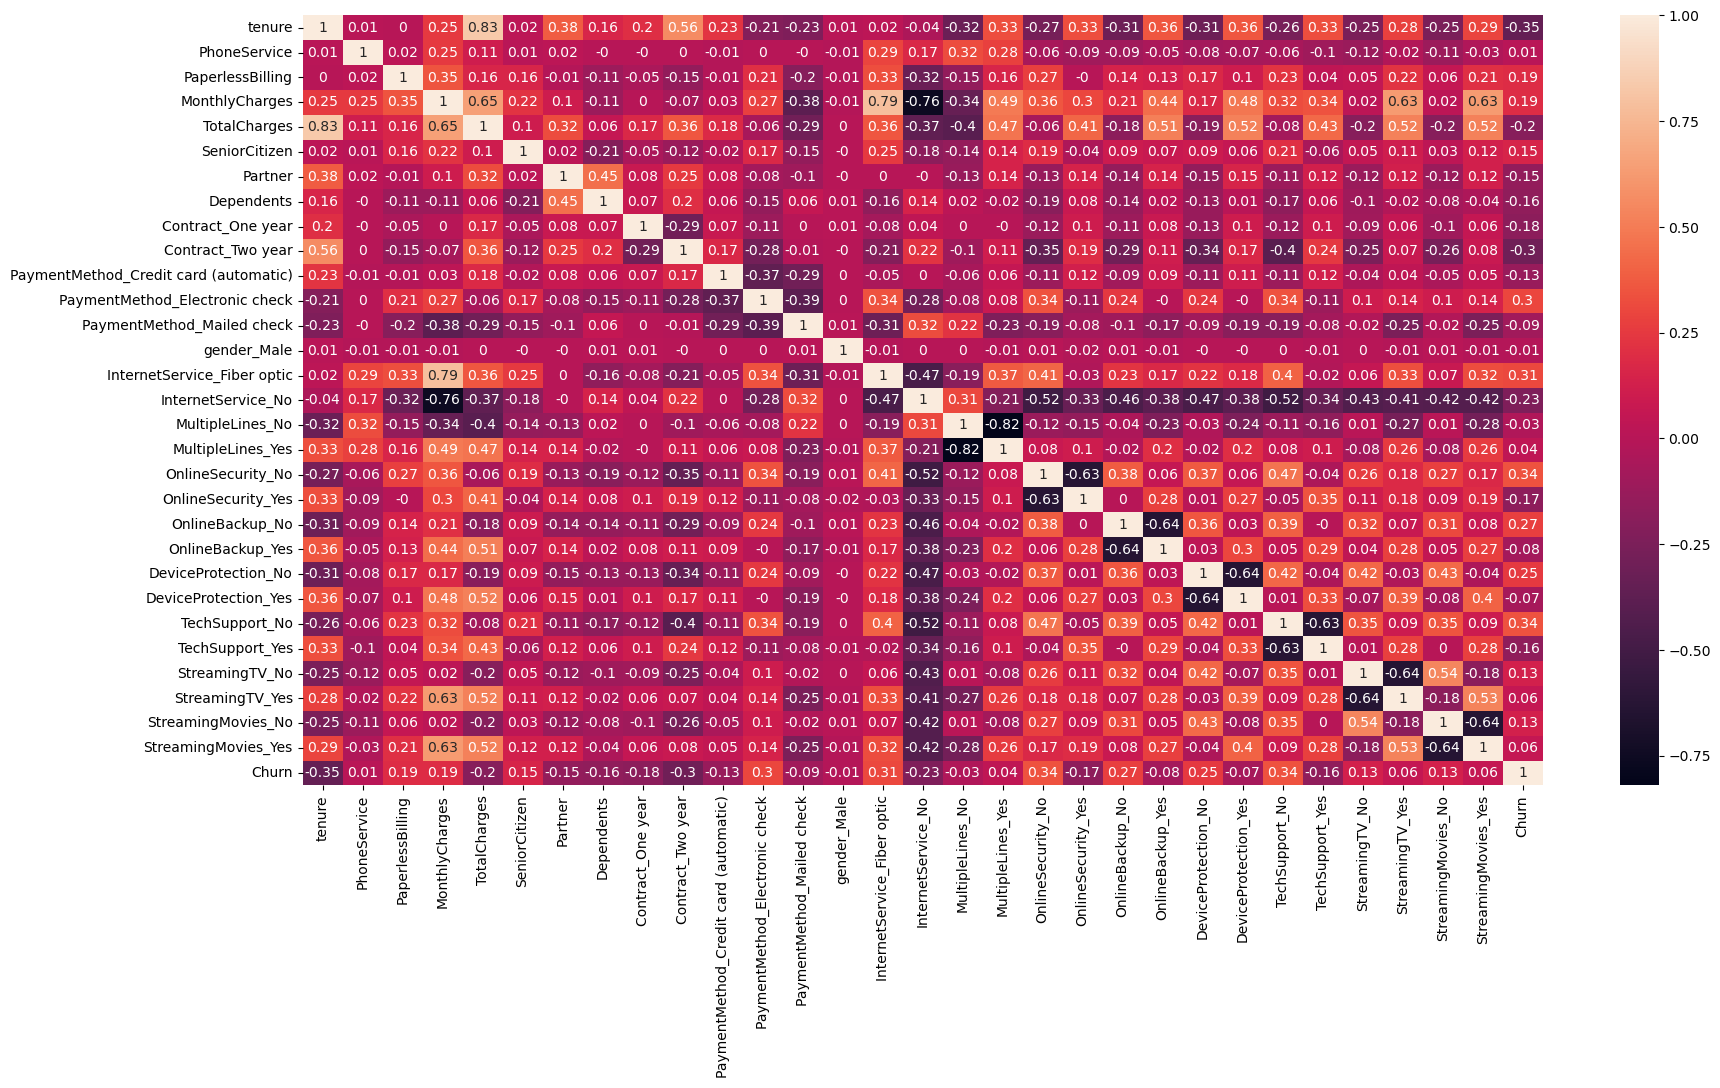

In [390]:
# Let's see the correlation matrix 
plt.figure(figsize = (20,10))        # Size of the figure
sns.heatmap(round(telecom.corr(),2),annot = True)
plt.show()

In [391]:
# Finding variables with whom churn has good correlation
temp_2 = round(telecom.corr()['Churn'].drop('Churn'),2)
temp_2[(temp_2 >= 0.30) | (temp_2 <= -0.30)]

tenure                           -0.35
Contract_Two year                -0.30
PaymentMethod_Electronic check    0.30
InternetService_Fiber optic       0.31
OnlineSecurity_No                 0.34
TechSupport_No                    0.34
Name: Churn, dtype: float64

* 'Churn' has good correlation (>= 0.30 & <=-0.30) with
    1. tenure
    2. Contract_Two_Year
    3. PaymentMethod_Electronic check
    4. InternetService_Fiber optic
    5. OnlineSecurity_No                 
    6. TechSupport_No
    
    
 We 'll try not to remove these.

In [392]:
data_wo_Churn = telecom.drop('Churn', axis=1)
data_wo_Churn

,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,Contract_One year,Contract_Two year,...,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes
0,1,0,1,29.85,29.85,0,1,0,0,0,...,0,1,1,0,1,0,1,0,1,0
1,34,1,0,56.95,1889.50,0,0,0,1,0,...,1,0,0,1,1,0,1,0,1,0
2,2,1,1,53.85,108.15,0,0,0,0,0,...,0,1,1,0,1,0,1,0,1,0
3,45,0,0,42.30,1840.75,0,0,0,1,0,...,1,0,0,1,0,1,1,0,1,0
4,2,1,1,70.70,151.65,0,0,0,0,0,...,1,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,24,1,1,84.80,1990.50,0,1,1,1,0,...,1,0,0,1,0,1,0,1,0,1
7039,72,1,1,103.20,7362.90,0,1,1,1,0,...,0,1,0,1,1,0,0,1,0,1
7040,11,0,1,29.60,346.45,0,1,1,0,0,...,1,0,1,0,1,0,1,0,1,0
7041,4,1,1,74.40,306.60,1,1,0,0,0,...,1,0,1,0,1,0,1,0,1,0


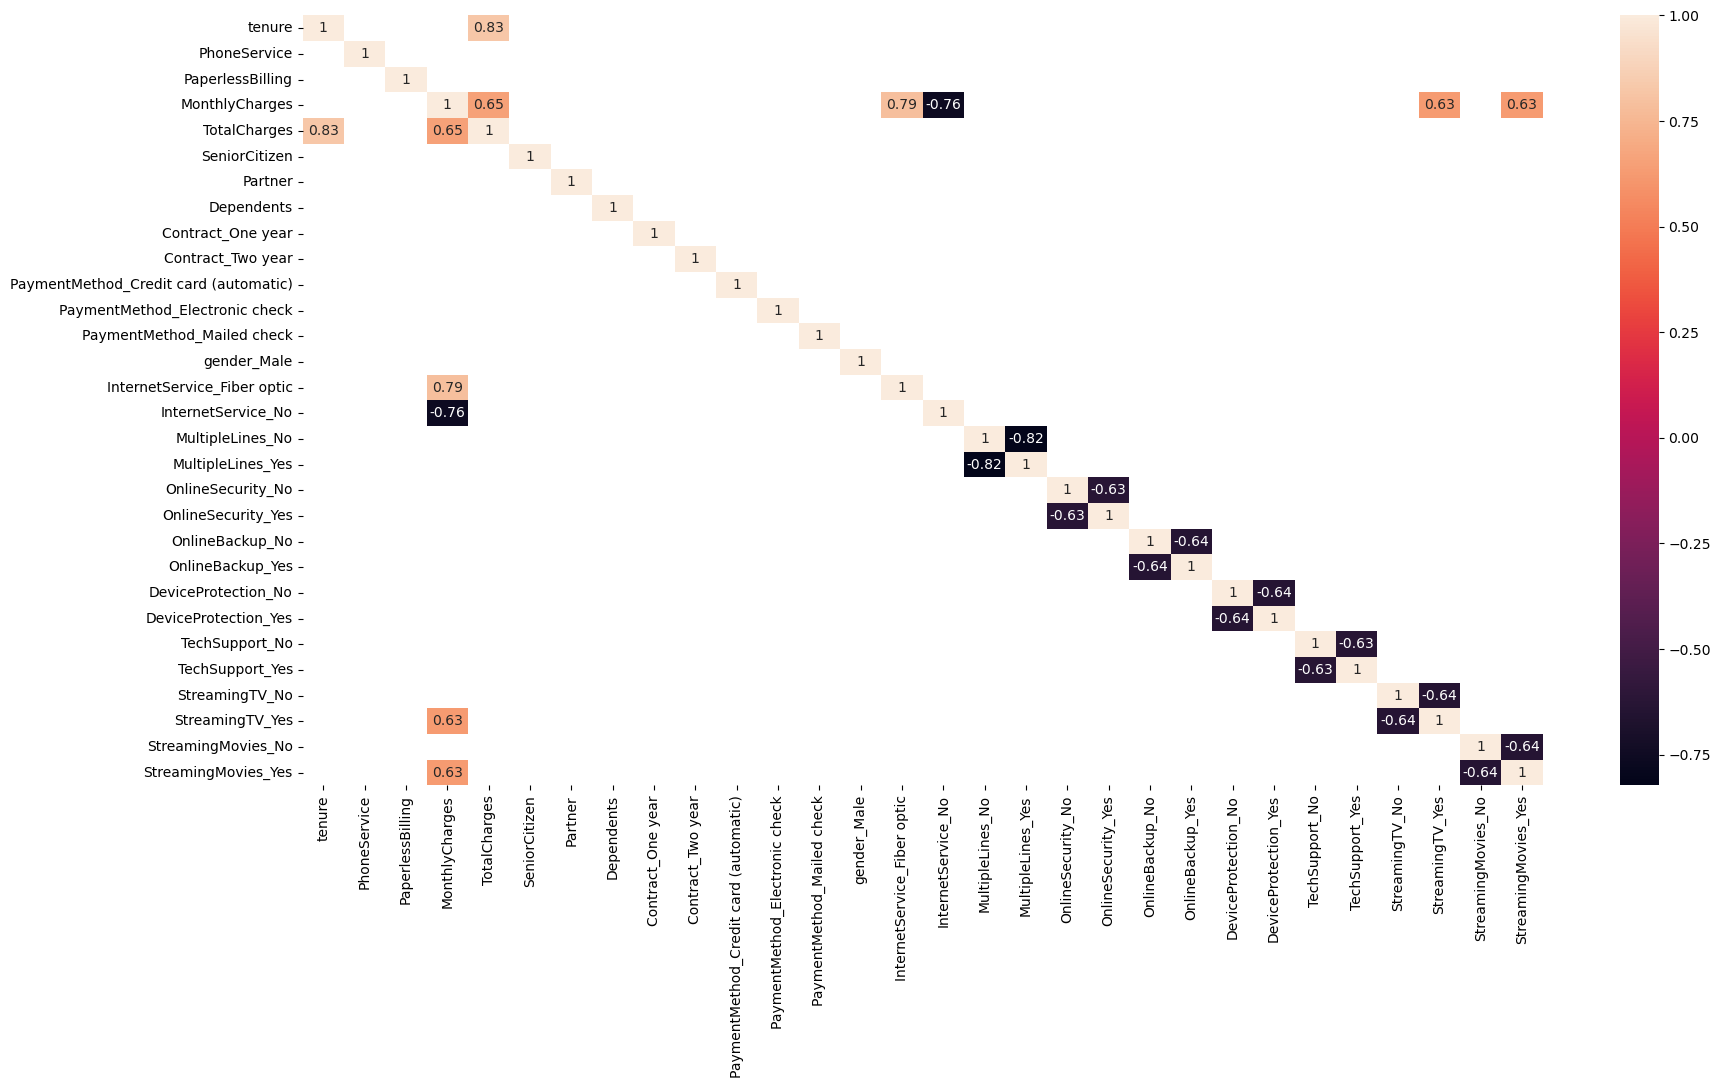

In [393]:
# # Let's see the correlation matrix 
plt.figure(figsize = (20,10))        # Size of the figure
sns.heatmap(data_wo_Churn.corr()[np.logical_or(data_wo_Churn.corr() > 0.60, data_wo_Churn.corr() < -0.60)],annot = True)
plt.show()

#### Dropping highly correlated dummy variables

In [394]:
X_test = X_test.drop(['MultipleLines_No','OnlineSecurity_No','OnlineBackup_No','DeviceProtection_No','TechSupport_No',
                       'StreamingTV_No','StreamingMovies_No'], 1)
X_train = X_train.drop(['MultipleLines_No','OnlineSecurity_No','OnlineBackup_No','DeviceProtection_No','TechSupport_No',
                         'StreamingTV_No','StreamingMovies_No'], 1)

#### Checking the Correlation Matrix

After dropping highly correlated variables now let's check the correlation matrix again.

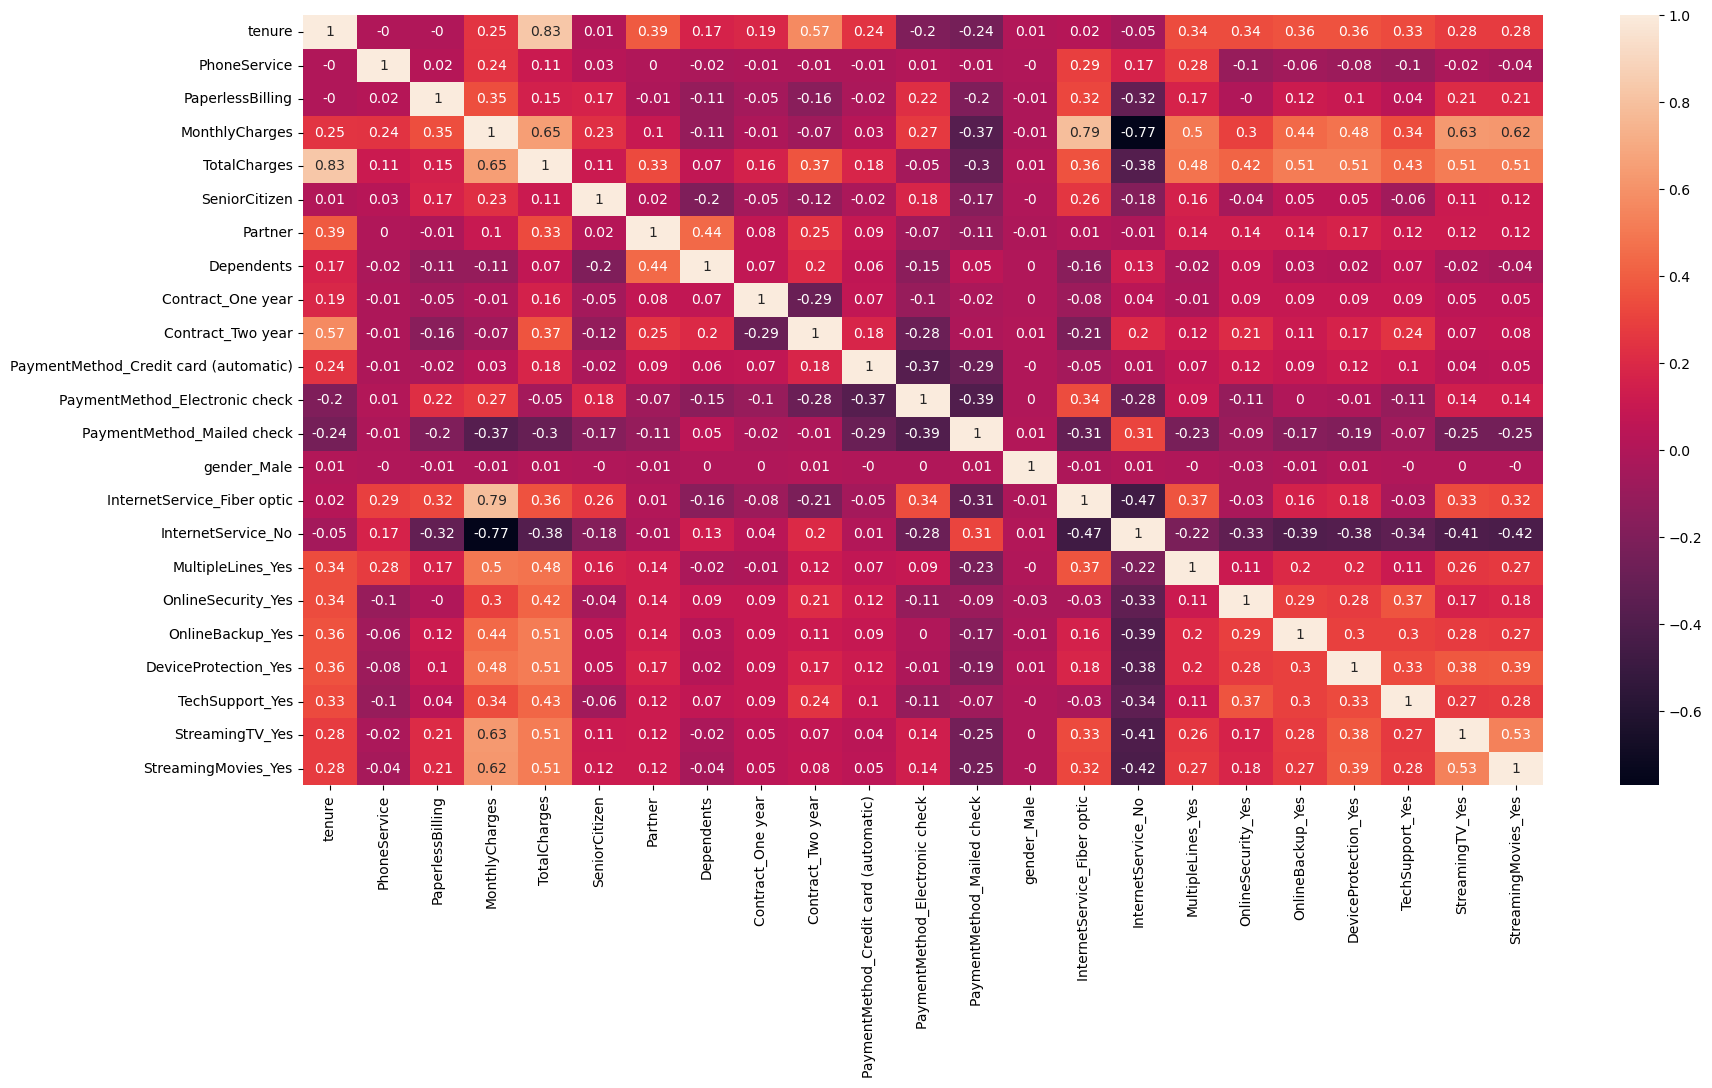

In [395]:
plt.figure(figsize = (20,10))
sns.heatmap(round(X_train.corr(),2),annot = True)
plt.show()

### Step 7: Model Building
Let's start by splitting our data into a training set and a test set.

#### Running Your First Training Model

In [396]:
import statsmodels.api as sm

In [397]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                            GLM   Df Residuals:                     4898
Model Family:                Binomial   Df Model:                           23
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2004.7
Date:                Mon, 24 Jul 2023   Deviance:                       4009.4
Time:                        12:41:25   Pearson chi2:                 6.07e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2844
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -3.9382      1.546     -2.547      0.011      -6.969      -0.908
tenure                                   -1.5172      0.189     -8.015      0.000      -1.888      -1.146
PhoneService                              0.9507      0.789      1.205      0.228      -0.595       2.497
PaperlessBilling                          0.3254      0.090      3.614      0.000       0.149       0.502
MonthlyCharges                           -2.1806      1.160     -1.880      0.060      -4.454       0.092
TotalCharges                              0.7332      0.198      3.705      0.000       0.345       1.121
SeniorCitizen                             0.3984      0.102      3.924      0.000       0.199       0.597
Partner                                   0.0374      0.094      0.399      0.690      -0.146       0.221
Dependents                               -0.1430      0.107     -1.332      0.183      -0.353       0.067
Contract_One year                        -0.6578      0.129     -5.106      0.000      -0.910      -0.405
Contract_Two year                        -1.2455      0.212     -5.874      0.000      -1.661      -0.830
PaymentMethod_Credit card (automatic)    -0.2577      0.137     -1.883      0.060      -0.526       0.011
PaymentMethod_Electronic check            0.1615      0.113      1.434      0.152      -0.059       0.382
PaymentMethod_Mailed check               -0.2536      0.137     -1.845      0.065      -0.523       0.016
gender_Male                              -0.0346      0.078     -0.442      0.658      -0.188       0.119
InternetService_Fiber optic               2.5124      0.967      2.599      0.009       0.618       4.407
InternetService_No                       -2.7792      0.982     -2.831      0.005      -4.703      -0.855
MultipleLines_Yes                         0.5623      0.214      2.628      0.009       0.143       0.982
OnlineSecurity_Yes                       -0.0245      0.216     -0.113      0.910      -0.448       0.399
OnlineBackup_Yes                          0.1740      0.212      0.822      0.411      -0.241       0.589
DeviceProtection_Yes                      0.3229      0.215      1.501      0.133      -0.099       0.744
TechSupport_Yes                          -0.0305      0.216     -0.141      0.888      -0.455       0.394
StreamingTV_Yes                           0.9598      0.396      2.423      0.015       0.183       1.736
StreamingMovies_Yes                       0.8484      0.396      2.143      0.032       0.072       1.624
=========================================================================================================
"""

### Step 8: Feature Selection Using RFE

In [398]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [399]:
from sklearn.feature_selection import RFE
rfe = RFE(estimator=logreg, n_features_to_select=15)             
rfe = rfe.fit(X_train, y_train)

In [400]:
rfe.support_

array([ True, False,  True,  True,  True,  True, False, False,  True,
        True,  True, False,  True, False,  True,  True,  True, False,
       False, False,  True,  True,  True])

In [401]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('tenure', True, 1),
 ('PhoneService', False, 3),
 ('PaperlessBilling', True, 1),
 ('MonthlyCharges', True, 1),
 ('TotalCharges', True, 1),
 ('SeniorCitizen', True, 1),
 ('Partner', False, 7),
 ('Dependents', False, 6),
 ('Contract_One year', True, 1),
 ('Contract_Two year', True, 1),
 ('PaymentMethod_Credit card (automatic)', True, 1),
 ('PaymentMethod_Electronic check', False, 4),
 ('PaymentMethod_Mailed check', True, 1),
 ('gender_Male', False, 8),
 ('InternetService_Fiber optic', True, 1),
 ('InternetService_No', True, 1),
 ('MultipleLines_Yes', True, 1),
 ('OnlineSecurity_Yes', False, 2),
 ('OnlineBackup_Yes', False, 5),
 ('DeviceProtection_Yes', False, 9),
 ('TechSupport_Yes', True, 1),
 ('StreamingTV_Yes', True, 1),
 ('StreamingMovies_Yes', True, 1)]

In [402]:
# Selected Features
col = X_train.columns[rfe.support_]
col

Index(['tenure', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
       'SeniorCitizen', 'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Mailed check',
       'InternetService_Fiber optic', 'InternetService_No',
       'MultipleLines_Yes', 'TechSupport_Yes', 'StreamingTV_Yes',
       'StreamingMovies_Yes'],
      dtype='object')

In [403]:
# Features not selected
X_train.columns[~rfe.support_]

Index(['PhoneService', 'Partner', 'Dependents',
       'PaymentMethod_Electronic check', 'gender_Male', 'OnlineSecurity_Yes',
       'OnlineBackup_Yes', 'DeviceProtection_Yes'],
      dtype='object')

##### Assessing the model with StatsModels

In [404]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                            GLM   Df Residuals:                     4906
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2011.1
Date:                Mon, 24 Jul 2023   Deviance:                       4022.2
Time:                        12:41:26   Pearson chi2:                 6.25e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2825
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -2.2462      0.189    -11.879      0.000      -2.617      -1.876
tenure                                   -1.5596      0.187     -8.334      0.000      -1.926      -1.193
PaperlessBilling                          0.3436      0.090      3.832      0.000       0.168       0.519
MonthlyCharges                           -0.9692      0.199     -4.878      0.000      -1.359      -0.580
TotalCharges                              0.7421      0.197      3.764      0.000       0.356       1.128
SeniorCitizen                             0.4296      0.100      4.312      0.000       0.234       0.625
Contract_One year                        -0.6830      0.128     -5.342      0.000      -0.934      -0.432
Contract_Two year                        -1.2931      0.211     -6.138      0.000      -1.706      -0.880
PaymentMethod_Credit card (automatic)    -0.3724      0.113     -3.308      0.001      -0.593      -0.152
PaymentMethod_Mailed check               -0.3723      0.111     -3.345      0.001      -0.591      -0.154
InternetService_Fiber optic               1.5865      0.216      7.342      0.000       1.163       2.010
InternetService_No                       -1.6897      0.216     -7.830      0.000      -2.113      -1.267
MultipleLines_Yes                         0.3779      0.104      3.640      0.000       0.174       0.581
TechSupport_Yes                          -0.2408      0.109     -2.210      0.027      -0.454      -0.027
StreamingTV_Yes                           0.5796      0.114      5.102      0.000       0.357       0.802
StreamingMovies_Yes                       0.4665      0.111      4.197      0.000       0.249       0.684
=========================================================================================================
"""

In [405]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.19264205, 0.27562384, 0.59950707, 0.51357126, 0.64823272,
       0.41484553, 0.43118361, 0.80178789, 0.22819404, 0.50457542])

##### Creating a dataframe with the actual churn flag and the predicted probabilities

In [406]:
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
#y_train_pred_final['CustID'] = y_train.index
y_train_pred_final.head()

,Churn,Churn_Prob
0,0,0.192642
1,0,0.275624
2,1,0.599507
3,1,0.513571
4,1,0.648233


In [407]:
# Getting the predicted values on the test set
y_train_pred = res.predict(X_train_sm)
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.19264205, 0.27562384, 0.59950707, 0.51357126, 0.64823272,
       0.41484553, 0.43118361, 0.80178789, 0.22819404, 0.50457542])

##### Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0

In [408]:
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

,Churn,Churn_Prob,predicted
0,0,0.192642,0
1,0,0.275624,0
2,1,0.599507,1
3,1,0.513571,1
4,1,0.648233,1


Note: Apart from the accuracy, Precision, Recall & various other metrics, our keen interest is minimizing the prediction of people who have churned but predicted as not churned i.e. False Negative ('Not Churned' Predicted).


In [409]:
metrics_df = pd.DataFrame(columns=['Model', 'Data', 'Precision', 'Recall', 'Specificity', 'False Negative %', 'Accuracy'])
metrics_df

,Model,Data,Precision,Recall,Specificity,False Negative,Accuracy


In [410]:
confusion_matrix_table, precision_value, recall_value, specificity_value, FN, accuracy_value = get_evaluation_metrics(y_train_pred_final, 'Churn', 'predicted', Print=True)

Confusion Matrix: 
 [[3275  360]
 [ 574  713]]
Precision Score:  0.6644920782851818
Recall Score:  0.554001554001554
Specificity:  0.9009628610729024
False Negative:  574
Accuracy:  0.8102397399431126


In [411]:
#                            Predicted     
#                      not_churn    churn
#     Actual
#   not_churn        3275 (TN)     360 (FP)
#     churn           574 (FN)     713 (TP) 

In [412]:
# Creating metrics list
metric_row = [ 'Logistic (all features)','Training Data', precision_value, recall_value, specificity_value, FN, accuracy_value]

# Adding metrics list to the dataframe
metrics_df.loc[len(metrics_df)] = metric_row

metrics_df

,Model,Data,Precision,Recall,Specificity,False Negative,Accuracy
0,Logistic (all features),Training Data,0.664492,0.554002,0.900963,574,0.81024


#### Checking VIFs

In [413]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [414]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,MonthlyCharges,14.85
3,TotalCharges,10.42
0,tenure,7.38
9,InternetService_Fiber optic,5.61
10,InternetService_No,5.27
6,Contract_Two year,3.14
13,StreamingTV_Yes,2.79
14,StreamingMovies_Yes,2.79
1,PaperlessBilling,2.76
11,MultipleLines_Yes,2.38


There are a few variables with high VIF. It's best to drop these variables as they aren't helping much with prediction and unnecessarily making the model complex. The variable 'MonthlyCharges' has the highest VIF. So let's start by dropping that.

In [415]:
col = col.drop('MonthlyCharges', 1)
col

Index(['tenure', 'PaperlessBilling', 'TotalCharges', 'SeniorCitizen',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Mailed check',
       'InternetService_Fiber optic', 'InternetService_No',
       'MultipleLines_Yes', 'TechSupport_Yes', 'StreamingTV_Yes',
       'StreamingMovies_Yes'],
      dtype='object')

In [416]:
# Let's re-run the model using the selected variables
X_train_sm = sm.add_constant(X_train[col])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                            GLM   Df Residuals:                     4907
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2023.1
Date:                Mon, 24 Jul 2023   Deviance:                       4046.2
Time:                        12:41:31   Pearson chi2:                 5.80e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2790
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -1.5971      0.130    -12.296      0.000      -1.852      -1.343
tenure                                   -1.3286      0.180     -7.401      0.000      -1.681      -0.977
PaperlessBilling                          0.3533      0.089      3.958      0.000       0.178       0.528
TotalCharges                              0.4347      0.186      2.340      0.019       0.071       0.799
SeniorCitizen                             0.4569      0.099      4.601      0.000       0.262       0.652
Contract_One year                        -0.7289      0.127     -5.729      0.000      -0.978      -0.480
Contract_Two year                        -1.3277      0.210     -6.322      0.000      -1.739      -0.916
PaymentMethod_Credit card (automatic)    -0.3870      0.112     -3.442      0.001      -0.607      -0.167
PaymentMethod_Mailed check               -0.3618      0.110     -3.274      0.001      -0.578      -0.145
InternetService_Fiber optic               0.6888      0.109      6.297      0.000       0.474       0.903
InternetService_No                       -0.9555      0.156     -6.120      0.000      -1.262      -0.649
MultipleLines_Yes                         0.1700      0.094      1.814      0.070      -0.014       0.354
TechSupport_Yes                          -0.4371      0.101     -4.307      0.000      -0.636      -0.238
StreamingTV_Yes                           0.2881      0.096      2.996      0.003       0.100       0.477
StreamingMovies_Yes                       0.1944      0.096      2.031      0.042       0.007       0.382
=========================================================================================================
"""

In [417]:
y_train_pred = res.predict(X_train_sm).values.reshape(-1)
y_train_pred_final['Churn_Prob'] = y_train_pred

# Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Churn,Churn_Prob,predicted
0,0,0.227902,0
1,0,0.228644,0
2,1,0.674892,1
3,1,0.615868,1
4,1,0.662260,1


In [418]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

0.8057700121901666


So overall the accuracy hasn't dropped much.

##### Let's check the VIFs again

In [419]:
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,TotalCharges,7.46
0,tenure,6.90
5,Contract_Two year,3.07
8,InternetService_Fiber optic,2.96
13,StreamingMovies_Yes,2.62
12,StreamingTV_Yes,2.59
1,PaperlessBilling,2.55
9,InternetService_No,2.44
10,MultipleLines_Yes,2.27
11,TechSupport_Yes,1.95


In [420]:
# Let's drop TotalCharges since it has a high VIF
col = col.drop('TotalCharges')
col

Index(['tenure', 'PaperlessBilling', 'SeniorCitizen', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Mailed check', 'InternetService_Fiber optic',
       'InternetService_No', 'MultipleLines_Yes', 'TechSupport_Yes',
       'StreamingTV_Yes', 'StreamingMovies_Yes'],
      dtype='object')

In [421]:
# Let's re-run the model using the selected variables
X_train_sm = sm.add_constant(X_train[col])
logm4 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm4.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                            GLM   Df Residuals:                     4908
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2025.9
Date:                Mon, 24 Jul 2023   Deviance:                       4051.9
Time:                        12:41:35   Pearson chi2:                 5.25e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2782
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -1.6577      0.127    -13.094      0.000      -1.906      -1.410
tenure                                   -0.9426      0.065    -14.480      0.000      -1.070      -0.815
PaperlessBilling                          0.3455      0.089      3.877      0.000       0.171       0.520
SeniorCitizen                             0.4597      0.100      4.613      0.000       0.264       0.655
Contract_One year                        -0.7218      0.127     -5.702      0.000      -0.970      -0.474
Contract_Two year                        -1.2987      0.208     -6.237      0.000      -1.707      -0.891
PaymentMethod_Credit card (automatic)    -0.3874      0.113     -3.442      0.001      -0.608      -0.167
PaymentMethod_Mailed check               -0.3307      0.110     -3.020      0.003      -0.545      -0.116
InternetService_Fiber optic               0.8052      0.097      8.272      0.000       0.614       0.996
InternetService_No                       -0.9726      0.155     -6.261      0.000      -1.277      -0.668
MultipleLines_Yes                         0.2097      0.092      2.279      0.023       0.029       0.390
TechSupport_Yes                          -0.4046      0.101     -4.019      0.000      -0.602      -0.207
StreamingTV_Yes                           0.3390      0.094      3.619      0.000       0.155       0.523
StreamingMovies_Yes                       0.2428      0.093      2.598      0.009       0.060       0.426
=========================================================================================================
"""

In [422]:
y_train_pred = res.predict(X_train_sm).values.reshape(-1)
y_train_pred_final['Churn_Prob'] = y_train_pred

# Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Churn,Churn_Prob,predicted
0,0,0.245817,0
1,0,0.265361,0
2,1,0.669410,1
3,1,0.630970,1
4,1,0.682916,1


##### Let's now check the VIFs again

In [423]:
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,Contract_Two year,2.98
7,InternetService_Fiber optic,2.67
12,StreamingMovies_Yes,2.54
11,StreamingTV_Yes,2.51
1,PaperlessBilling,2.45
9,MultipleLines_Yes,2.24
0,tenure,2.04
8,InternetService_No,2.03
10,TechSupport_Yes,1.92
3,Contract_One year,1.78


All variables have a good value of VIF. So we need not drop any more variables and we can proceed with making predictions using this model only

### Step 9: Model Performance

In [424]:
confusion_matrix_table, precision_value, recall_value, specificity_value, FN, accuracy_value = get_evaluation_metrics(y_train_pred_final, 'Churn', 'predicted', Print=True)

Confusion Matrix: 
 [[3278  357]
 [ 597  690]]
Precision Score:  0.6590257879656161
Recall Score:  0.5361305361305362
Specificity:  0.9017881705639614
False Negative:  597
Accuracy:  0.8061763510767981


The accuracy is still practically the same.

In [425]:
# Creating metrics list
metric_row = [ 'Logistic (13 features - 0.5 cutoff)','Training Data', precision_value, recall_value, specificity_value, FN, accuracy_value]

# Adding metrics list to the dataframe
metrics_df.loc[len(metrics_df)] = metric_row

metrics_df

,Model,Data,Precision,Recall,Specificity,False Negative,Accuracy
0,Logistic (all features),Training Data,0.664492,0.554002,0.900963,574,0.810240
1,Logistic (13 features - 0.5 cutoff),Training Data,0.659026,0.536131,0.901788,597,0.806176


#### Plotting the ROC Curve

In [426]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False)
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (1 - True Negative Rate)')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

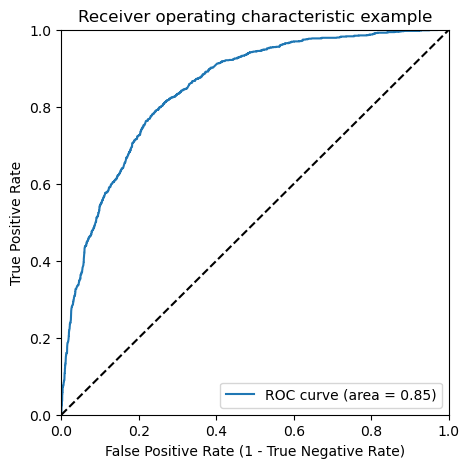

In [427]:
draw_roc(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)

ROC curve demonstrates several things:

- It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).
- The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
- The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

### Step 10: Finding Optimal Cutoff Point

Optimal cutoff probability is that prob where we get balanced sensitivity and specificity

In [428]:
# Let's create columns with different probability cutoffs

# This creates cut-off ranging from 0.0 to 0.9
numbers = [float(x)/10 for x in range(10)]

for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Churn,Churn_Prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.245817,0,1,1,1,0,0,0,0,0,0,0
1,0,0.265361,0,1,1,1,0,0,0,0,0,0,0
2,1,0.669410,1,1,1,1,1,1,1,1,0,0,0
3,1,0.630970,1,1,1,1,1,1,1,1,0,0,0
4,1,0.682916,1,1,1,1,1,1,1,1,0,0,0


In [429]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.261479  1.000000  0.000000
0.1   0.1  0.614994  0.943279  0.498762
0.2   0.2  0.721861  0.846154  0.677854
0.3   0.3  0.770012  0.776224  0.767813
0.4   0.4  0.790532  0.636364  0.845117
0.5   0.5  0.806176  0.536131  0.901788
0.6   0.6  0.798050  0.380730  0.945805
0.7   0.7  0.776310  0.196581  0.981568
0.8   0.8  0.747867  0.041181  0.998074
0.9   0.9  0.738521  0.000000  1.000000


In [430]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    confusion_matrix_table, precision_value, recall_value, specificity_value, FN, accuracy_value = get_evaluation_metrics(y_train_pred_final, 'Churn', i)
    #cm1 = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final[i] )
    #total1=sum(sum(confusion_matrix_table))
    #accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    #speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    #sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy_value,recall_value,specificity_value]
print(cutoff_df)

Confusion Matrix: 
 [[   0 3635]
 [   0 1287]]
Precision Score:  0.26147907354733846
Recall Score:  1.0
Specificity:  0.0
False Negative:  0
Accuracy:  0.26147907354733846
Confusion Matrix: 
 [[1813 1822]
 [  73 1214]]
Precision Score:  0.39986824769433466
Recall Score:  0.9432789432789432
Specificity:  0.49876203576341127
False Negative:  73
Accuracy:  0.6149939049167005
Confusion Matrix: 
 [[2464 1171]
 [ 198 1089]]
Precision Score:  0.481858407079646
Recall Score:  0.8461538461538461
Specificity:  0.6778541953232462
False Negative:  198
Accuracy:  0.721861032100772
Confusion Matrix: 
 [[2791  844]
 [ 288  999]]
Precision Score:  0.5420510037981552
Recall Score:  0.7762237762237763
Specificity:  0.7678129298486933
False Negative:  288
Accuracy:  0.7700121901665989
Confusion Matrix: 
 [[3072  563]
 [ 468  819]]
Precision Score:  0.5926193921852387
Recall Score:  0.6363636363636364
Specificity:  0.8451169188445667
False Negative:  468
Accuracy:  0.7905323039414872
Confusion Matrix: 
 [

#### Calculating Intersection

In [431]:
# Step 1: Calculates the difference b/w the sensitivity & specificity
diff = cutoff_df['sensi'] - cutoff_df['speci']
diff

0.0    1.000000
0.1    0.444517
0.2    0.168300
0.3    0.008411
0.4   -0.208753
0.5   -0.365658
0.6   -0.565074
0.7   -0.784987
0.8   -0.956893
0.9   -1.000000
dtype: float64

In [432]:
# Step 2: Changing -ve, +ve & 0 values with '-1', '+1' & 0 respectively
converted_diff = np.sign(diff)
converted_diff

0.0    1.0
0.1    1.0
0.2    1.0
0.3    1.0
0.4   -1.0
0.5   -1.0
0.6   -1.0
0.7   -1.0
0.8   -1.0
0.9   -1.0
dtype: float64

In [433]:
# Step 3: calculates the differences between consecutive elements in the series obtained above using which we can detect changes in sign which indicates the intersections
consecutive_diff = np.diff(converted_diff)
consecutive_diff

array([ 0.,  0.,  0., -2.,  0.,  0.,  0.,  0.,  0.])

In [434]:
# Step 4: Using the above series, we extract the index where we notice the change in sign & flattening it to get a 1-D array
intersection = np.argwhere(consecutive_diff).flatten()
intersection

array([3], dtype=int64)

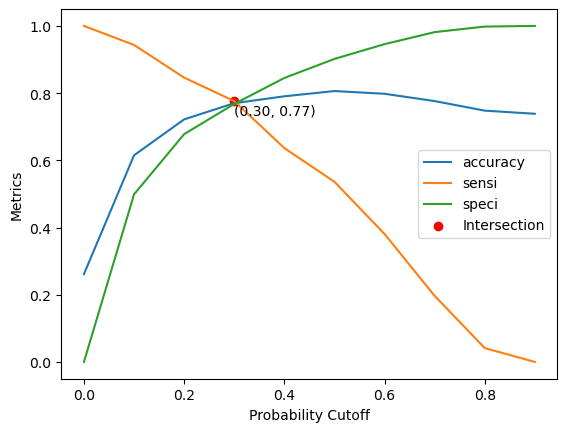

In [435]:
# Plot the lines
cutoff_df.plot.line(x='prob', y=['accuracy', 'sensi', 'speci'])
plt.xlabel('Probability Cutoff')
plt.ylabel('Metrics')

# Highlight the intersections with a red dot
plt.scatter(cutoff_df['prob'].iloc[intersection], cutoff_df['sensi'].iloc[intersection], color='red', label='Intersection')

# Adding the co-ordinates of the intersection
x_coord = cutoff_df['prob'].iloc[intersection].item()   # Getting value from the series
y_coord = cutoff_df['speci'].iloc[intersection].item()  # Getting value from the series
plt.text(x_coord, y_coord, f'({x_coord:.2f}, {y_coord:.2f})', verticalalignment='top', horizontalalignment='left')

# Show the plot
plt.legend()
plt.show()

#### From the curve above, 0.3 is the optimum point to take it as a cutoff probability.

In [436]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.3 else 0)
y_train_pred_final.head()

,Churn,Churn_Prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.245817,0,1,1,1,0,0,0,0,0,0,0,0
1,0,0.265361,0,1,1,1,0,0,0,0,0,0,0,0
2,1,0.669410,1,1,1,1,1,1,1,1,0,0,0,1
3,1,0.630970,1,1,1,1,1,1,1,1,0,0,0,1
4,1,0.682916,1,1,1,1,1,1,1,1,0,0,0,1


In [437]:
confusion_matrix_table, precision_value, recall_value, specificity_value, FN, accuracy_value = get_evaluation_metrics(y_train_pred_final, 'Churn', 'final_predicted')

Confusion Matrix: 
 [[2791  844]
 [ 288  999]]
Precision Score:  0.5420510037981552
Recall Score:  0.7762237762237763
Specificity:  0.7678129298486933
False Negative:  288
Accuracy:  0.7700121901665989


In [438]:
# Creating metrics list
metric_row = [ 'Logistic (13 features - 0.3 cutoff)','Training Data', precision_value, recall_value, specificity_value, FN, accuracy_value]

# Adding metrics list to the dataframe
metrics_df.loc[len(metrics_df)] = metric_row

metrics_df

,Model,Data,Precision,Recall,Specificity,False Negative,Accuracy
0,Logistic (all features),Training Data,0.664492,0.554002,0.900963,574,0.810240
1,Logistic (13 features - 0.5 cutoff),Training Data,0.659026,0.536131,0.901788,597,0.806176
2,Logistic (13 features - 0.3 cutoff),Training Data,0.542051,0.776224,0.767813,288,0.770012


Though, the accuracy has reduced but the no. of false negative has reduced drastically which is good from business POV as the no. of people who have actually churned but predicted not churned has reduced

#### Precision and recall tradeoff

In [439]:
from sklearn.metrics import precision_recall_curve

In [440]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)

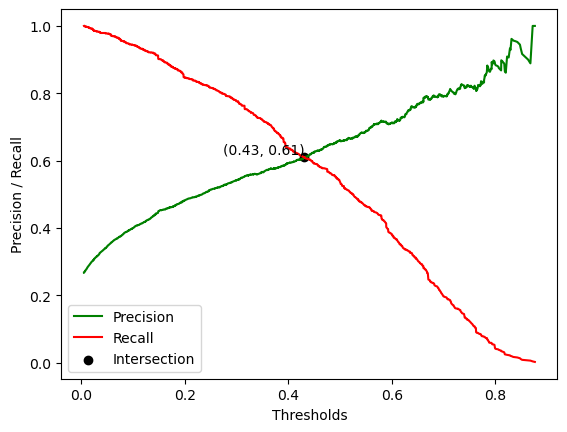

In [441]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have defined 'thresholds', 'p', and 'r' arrays

# Find intersection points

# Step 1: np.isclose() function finds approximate equality between corresponding elements of the two arrays
approx_equal_value = np.isclose(p[:-1], r[:-1])

# Step 2: np.where() function find the indices of 'approx_equal_value'
index_approx_equal_value = np.where(approx_equal_value)

# Step 3: Get the actual index value
intersection = index_approx_equal_value[0].item()

# Plot the graph
plt.plot(thresholds, p[:-1], "g-", label="Precision")
plt.plot(thresholds, r[:-1], "r-", label="Recall")

# Plot intersection points
plt.scatter(thresholds[intersection], p[intersection], c='black', marker='o', label='Intersection')

# Add coordinates as text annotations
#for i in intersections:
plt.text(thresholds[intersection], p[intersection], f'({thresholds[intersection]:.2f}, {p[intersection]:.2f})', color='black', verticalalignment='bottom', horizontalalignment='right')
#plt.text(thresholds[i], r[i], f'({thresholds[i]:.2f}, {r[i]:.2f})', color='black', verticalalignment='top', horizontalalignment='right')

# Add legend and labels
plt.legend()
plt.xlabel('Thresholds')
plt.ylabel('Precision / Recall')

# Show the plot
plt.show()

At '0.43', we have almost equal precision & recall.

### Step 11: Making predictions on the test set

In [442]:
X_test[['tenure','MonthlyCharges','TotalCharges']] = scaler.transform(X_test[['tenure','MonthlyCharges','TotalCharges']])

In [443]:
X_test = X_test[col]
X_test.head()

,tenure,PaperlessBilling,SeniorCitizen,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No,MultipleLines_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes
942,-0.347623,1,0,0,0,1,0,1,0,0,0,0,1
3730,0.999203,1,0,0,0,1,0,1,0,1,0,1,1
1761,1.040015,1,0,0,1,1,0,0,1,1,0,0,0
2283,-1.286319,1,0,0,0,0,1,1,0,0,0,0,0
1872,0.346196,0,0,0,1,0,0,0,1,0,0,0,0


In [444]:
X_test_sm = sm.add_constant(X_test)

Making predictions on the test set

In [445]:
y_test_pred = res.predict(X_test_sm)

In [446]:
y_test_pred[:10]

942     0.419725
3730    0.260232
1761    0.008650
2283    0.592626
1872    0.013989
1970    0.692893
2532    0.285289
1616    0.008994
2485    0.602307
5914    0.145153
dtype: float64

In [447]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred,columns=['Churn_Prob'])

In [448]:
# Let's see the head
y_pred_1.head()

,Churn_Prob
942,0.419725
3730,0.260232
1761,0.008650
2283,0.592626
1872,0.013989


In [449]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

In [450]:
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

In [451]:
# Let's see the head of y_pred_final
y_pred_final.head()

,Churn,Churn_Prob
0,0,0.419725
1,1,0.260232
2,0,0.008650
3,1,0.592626
4,0,0.013989


In [452]:
# USING '0.43' AS THE CUT-OFF PROBABILITY
y_pred_final['final_predicted_0.30'] = y_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.30 else 0)
y_pred_final['final_predicted_0.43'] = y_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.43 else 0)

In [453]:
y_pred_final.head()

,Churn,Churn_Prob,final_predicted_0.30,final_predicted_0.43
0,0,0.419725,1,0
1,1,0.260232,0,0
2,0,0.008650,0,0
3,1,0.592626,1,1
4,0,0.013989,0,0


In [454]:
# final_predicted_0.30
confusion_matrix_table, precision_value, recall_value, specificity_value, FN, accuracy_value = get_evaluation_metrics(y_pred_final, 'Churn', 'final_predicted_0.30')

Confusion Matrix: 
 [[1144  384]
 [ 163  419]]
Precision Score:  0.5217932752179327
Recall Score:  0.7199312714776632
Specificity:  0.7486910994764397
False Negative:  163
Accuracy:  0.7407582938388626


In [455]:
# Creating metrics list
metric_row = [ 'Logistic (13 features - 0.30 cutoff)','Test Data', precision_value, recall_value, specificity_value, FN, accuracy_value]

# Adding metrics list to the dataframe
metrics_df.loc[len(metrics_df)] = metric_row

metrics_df

,Model,Data,Precision,Recall,Specificity,False Negative,Accuracy
0,Logistic (all features),Training Data,0.664492,0.554002,0.900963,574,0.810240
1,Logistic (13 features - 0.5 cutoff),Training Data,0.659026,0.536131,0.901788,597,0.806176
2,Logistic (13 features - 0.3 cutoff),Training Data,0.542051,0.776224,0.767813,288,0.770012
3,Logistic (13 features - 0.30 cutoff),Test Data,0.521793,0.719931,0.748691,163,0.740758


In [456]:
# final_predicted_0.43
confusion_matrix_table, precision_value, recall_value, specificity_value, FN, accuracy_value = get_evaluation_metrics(y_pred_final, 'Churn', 'final_predicted_0.43')

Confusion Matrix: 
 [[1297  231]
 [ 218  364]]
Precision Score:  0.611764705882353
Recall Score:  0.6254295532646048
Specificity:  0.8488219895287958
False Negative:  218
Accuracy:  0.7872037914691943


In [457]:
# Creating metrics list
metric_row = [ 'Logistic (13 features - 0.43 cutoff)','Test Data', precision_value, recall_value, specificity_value, FN, accuracy_value]

# Adding metrics list to the dataframe
metrics_df.loc[len(metrics_df)] = metric_row

metrics_df

,Model,Data,Precision,Recall,Specificity,False Negative,Accuracy
0,Logistic (all features),Training Data,0.664492,0.554002,0.900963,574,0.810240
1,Logistic (13 features - 0.5 cutoff),Training Data,0.659026,0.536131,0.901788,597,0.806176
2,Logistic (13 features - 0.3 cutoff),Training Data,0.542051,0.776224,0.767813,288,0.770012
3,Logistic (13 features - 0.30 cutoff),Test Data,0.521793,0.719931,0.748691,163,0.740758
4,Logistic (13 features - 0.43 cutoff),Test Data,0.611765,0.625430,0.848822,218,0.787204


Stats:   
   
    Cut-off     False Negative %     Accuracy  
   
    0.30        7.7% (163/ 2113)      0.74
    
    0.43        10.3% (218/ 2113)     0.78
 
The loss in accuracy over powers the improvement in 'False Negative' %. Therefore, it is better to stick with 0.30 as the cut-off.

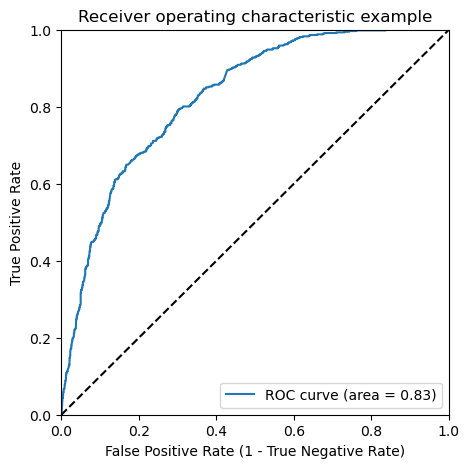

In [459]:
draw_roc(y_pred_final.Churn, y_pred_final.Churn_Prob)

## Using Decision Trees

In [460]:
# Putting feature variable to X
X_dt = telecom.drop('Churn', axis=1)
X_dt.head()

,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,Contract_One year,Contract_Two year,...,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes
0,1,0,1,29.85,29.85,0,1,0,0,0,...,0,1,1,0,1,0,1,0,1,0
1,34,1,0,56.95,1889.50,0,0,0,1,0,...,1,0,0,1,1,0,1,0,1,0
2,2,1,1,53.85,108.15,0,0,0,0,0,...,0,1,1,0,1,0,1,0,1,0
3,45,0,0,42.30,1840.75,0,0,0,1,0,...,1,0,0,1,0,1,1,0,1,0
4,2,1,1,70.70,151.65,0,0,0,0,0,...,1,0,1,0,1,0,1,0,1,0


In [461]:
# Putting response variable to y
y_dt = telecom['Churn']
y_dt

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7032, dtype: int64

In [462]:
X_train, X_test, y_train, y_test = train_test_split(X_dt, y_dt, train_size=0.7, random_state=100)

In [463]:
type(y_train)

pandas.core.series.Series

In [464]:
X_train.shape, X_test.shape

((4922, 30), (2110, 30))

In [465]:
from sklearn.tree import DecisionTreeClassifier

In [466]:
dt_base = DecisionTreeClassifier(random_state=42, max_depth=4)

In [467]:
dt_base.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

In [468]:
y_train_pred = dt_base.predict(X_train)
y_test_pred = dt_base.predict(X_test)

In [469]:
train_final_table = pd.DataFrame()

train_final_table['Churn'] = pd.DataFrame(y_train)
train_final_table['Predicted'] = y_train_pred
train_final_table

,Churn,Predicted
879,0,0
5790,0,0
6498,1,1
880,1,0
2784,1,1
...,...,...
79,0,0
3934,0,0
5964,0,0
6947,0,0


In [477]:
confusion_matrix_table, precision_value, recall_value, specificity_value, FN, accuracy_value = get_evaluation_metrics(train_final_table, 'Churn', 'Predicted', Print=True)

Confusion Matrix: 
 [[3370  265]
 [ 723  564]]
Precision Score:  0.6803377563329313
Recall Score:  0.4382284382284382
Specificity:  0.9270976616231087
False Negative %: 14.68915075172694 (723)
Accuracy:  0.7992685900040634


In [480]:
# Creating metrics list
metric_row = [ 'Decision Tree (Base)','Training Data', precision_value, recall_value, specificity_value, FN, accuracy_value]

# Adding metrics list to the dataframe
metrics_df.loc[len(metrics_df)] = metric_row

metrics_df

,Model,Data,Precision,Recall,Specificity,False Negative,Accuracy
0,Logistic (all features),Training Data,0.664492,0.554002,0.900963,574.000000,0.810240
1,Logistic (13 features - 0.5 cutoff),Training Data,0.659026,0.536131,0.901788,597.000000,0.806176
2,Logistic (13 features - 0.3 cutoff),Training Data,0.542051,0.776224,0.767813,288.000000,0.770012
3,Logistic (13 features - 0.30 cutoff),Test Data,0.521793,0.719931,0.748691,163.000000,0.740758
4,Logistic (13 features - 0.43 cutoff),Test Data,0.611765,0.625430,0.848822,218.000000,0.787204
5,Decision Tree (Base),Training Data,0.680338,0.438228,0.927098,14.689151,0.799269


In [481]:
test_final_table = pd.DataFrame()

test_final_table['Churn'] = pd.DataFrame(y_test)
test_final_table['Predicted'] = y_test_pred
test_final_table

,Churn,Predicted
942,0,0
3730,1,0
1761,0,0
2283,1,1
1872,0,0
...,...,...
1289,0,0
3508,0,0
6765,0,0
3598,0,1


In [482]:
confusion_matrix_table, precision_value, recall_value, specificity_value, FN, accuracy_value = get_evaluation_metrics(test_final_table, 'Churn', 'Predicted', Print=True)

Confusion Matrix: 
 [[1401  127]
 [ 320  262]]
Precision Score:  0.6735218508997429
Recall Score:  0.45017182130584193
Specificity:  0.9168848167539267
False Negative %: 15.165876777251185 (320)
Accuracy:  0.7881516587677725


In [483]:
# Creating metrics list
metric_row = [ 'Decision Tree (Base)','Test Data', precision_value, recall_value, specificity_value, FN, accuracy_value]

# Adding metrics list to the dataframe
metrics_df.loc[len(metrics_df)] = metric_row

metrics_df

,Model,Data,Precision,Recall,Specificity,False Negative,Accuracy
0,Logistic (all features),Training Data,0.664492,0.554002,0.900963,574.000000,0.810240
1,Logistic (13 features - 0.5 cutoff),Training Data,0.659026,0.536131,0.901788,597.000000,0.806176
2,Logistic (13 features - 0.3 cutoff),Training Data,0.542051,0.776224,0.767813,288.000000,0.770012
3,Logistic (13 features - 0.30 cutoff),Test Data,0.521793,0.719931,0.748691,163.000000,0.740758
4,Logistic (13 features - 0.43 cutoff),Test Data,0.611765,0.625430,0.848822,218.000000,0.787204
5,Decision Tree (Base),Training Data,0.680338,0.438228,0.927098,14.689151,0.799269
6,Decision Tree (Base),Test Data,0.673522,0.450172,0.916885,15.165877,0.788152


#### Plot the ROC curve

In [484]:
from sklearn.metrics import plot_roc_curve

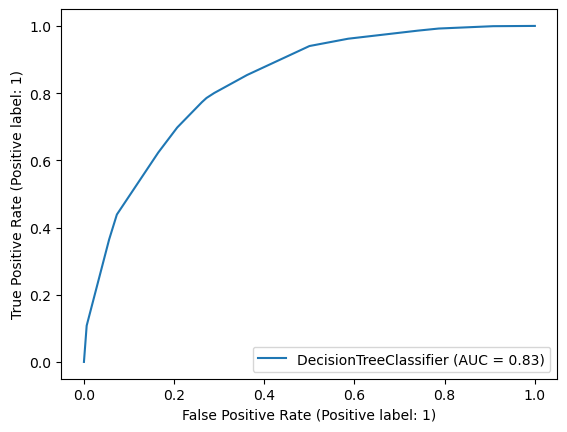

In [485]:
plot_roc_curve(dt_base, X_train, y_train, drop_intermediate=False)
plt.show()

#### Hyper-parameter tuning for the Decision Tree

In [486]:
from sklearn.model_selection import GridSearchCV

In [487]:
dt = DecisionTreeClassifier(random_state=42)

In [488]:
params = {
    "max_depth": [2,3,5,10,20],
    "min_samples_leaf": [5,10,20,50,100,500]
}

In [489]:
grid_search = GridSearchCV(estimator=dt,
                           param_grid=params,
                           cv=4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [490]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 30 candidates, totalling 120 fits
Wall time: 8.82 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 500]},
             scoring='accuracy', verbose=1)

In [491]:
grid_search.best_score_

0.7986589658747929

In [492]:
dt_best = grid_search.best_estimator_
dt_best

DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, random_state=42)

In [493]:
y_train_pred = dt_best.predict(X_train)
y_test_pred = dt_best.predict(X_test)

In [494]:
train_final_table = pd.DataFrame()

train_final_table['Churn'] = pd.DataFrame(y_train)
train_final_table['Predicted'] = y_train_pred
train_final_table

,Churn,Predicted
879,0,0
5790,0,0
6498,1,1
880,1,1
2784,1,1
...,...,...
79,0,0
3934,0,0
5964,0,0
6947,0,0


In [495]:
confusion_matrix_table, precision_value, recall_value, specificity_value, FN, accuracy_value = get_evaluation_metrics(train_final_table, 'Churn', 'Predicted', Print=True)

Confusion Matrix: 
 [[3307  328]
 [ 587  700]]
Precision Score:  0.6809338521400778
Recall Score:  0.5439005439005439
Specificity:  0.9097661623108666
False Negative %: 11.926046322633075 (587)
Accuracy:  0.8140999593661113


In [496]:
# Creating metrics list
metric_row = [ 'Decision Tree (Best)','Training Data', precision_value, recall_value, specificity_value, FN, accuracy_value]

# Adding metrics list to the dataframe
metrics_df.loc[len(metrics_df)] = metric_row

metrics_df

,Model,Data,Precision,Recall,Specificity,False Negative,Accuracy
0,Logistic (all features),Training Data,0.664492,0.554002,0.900963,574.000000,0.810240
1,Logistic (13 features - 0.5 cutoff),Training Data,0.659026,0.536131,0.901788,597.000000,0.806176
2,Logistic (13 features - 0.3 cutoff),Training Data,0.542051,0.776224,0.767813,288.000000,0.770012
3,Logistic (13 features - 0.30 cutoff),Test Data,0.521793,0.719931,0.748691,163.000000,0.740758
4,Logistic (13 features - 0.43 cutoff),Test Data,0.611765,0.625430,0.848822,218.000000,0.787204
5,Decision Tree (Base),Training Data,0.680338,0.438228,0.927098,14.689151,0.799269
6,Decision Tree (Base),Test Data,0.673522,0.450172,0.916885,15.165877,0.788152
7,Decision Tree (Best),Training Data,0.680934,0.543901,0.909766,11.926046,0.814100


In [497]:
test_final_table = pd.DataFrame()

test_final_table['Churn'] = pd.DataFrame(y_test)
test_final_table['Predicted'] = y_test_pred
test_final_table

,Churn,Predicted
942,0,0
3730,1,0
1761,0,0
2283,1,1
1872,0,0
...,...,...
1289,0,0
3508,0,0
6765,0,0
3598,0,1


In [498]:
confusion_matrix_table, precision_value, recall_value, specificity_value, FN, accuracy_value = get_evaluation_metrics(test_final_table, 'Churn', 'Predicted', Print=True)

Confusion Matrix: 
 [[1369  159]
 [ 270  312]]
Precision Score:  0.6624203821656051
Recall Score:  0.5360824742268041
Specificity:  0.8959424083769634
False Negative %: 12.796208530805686 (270)
Accuracy:  0.7966824644549763


In [499]:
# Creating metrics list
metric_row = [ 'Decision Tree (Best)','Test Data', precision_value, recall_value, specificity_value, FN, accuracy_value]

# Adding metrics list to the dataframe
metrics_df.loc[len(metrics_df)] = metric_row

metrics_df

,Model,Data,Precision,Recall,Specificity,False Negative,Accuracy
0,Logistic (all features),Training Data,0.664492,0.554002,0.900963,574.000000,0.810240
1,Logistic (13 features - 0.5 cutoff),Training Data,0.659026,0.536131,0.901788,597.000000,0.806176
2,Logistic (13 features - 0.3 cutoff),Training Data,0.542051,0.776224,0.767813,288.000000,0.770012
3,Logistic (13 features - 0.30 cutoff),Test Data,0.521793,0.719931,0.748691,163.000000,0.740758
4,Logistic (13 features - 0.43 cutoff),Test Data,0.611765,0.625430,0.848822,218.000000,0.787204
5,Decision Tree (Base),Training Data,0.680338,0.438228,0.927098,14.689151,0.799269
6,Decision Tree (Base),Test Data,0.673522,0.450172,0.916885,15.165877,0.788152
7,Decision Tree (Best),Training Data,0.680934,0.543901,0.909766,11.926046,0.814100
8,Decision Tree (Base),Test Data,0.662420,0.536082,0.895942,12.796209,0.796682


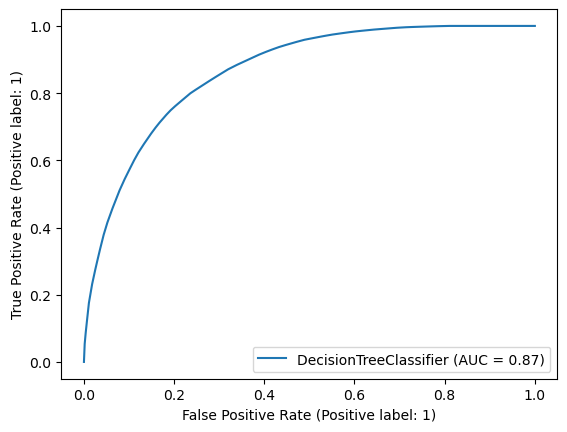

In [500]:
plot_roc_curve(dt_best, X_train, y_train)
plt.show()

## Using Random Forest

In [501]:
from sklearn.ensemble import RandomForestClassifier

In [502]:
rf = RandomForestClassifier(n_estimators=10, max_depth=4, max_features=5, random_state=100, oob_score=True)

In [503]:
%%time
rf.fit(X_train, y_train)

Wall time: 102 ms


RandomForestClassifier(max_depth=4, max_features=5, n_estimators=10,
                       oob_score=True, random_state=100)

In [504]:
rf.oob_score_

0.7850467289719626

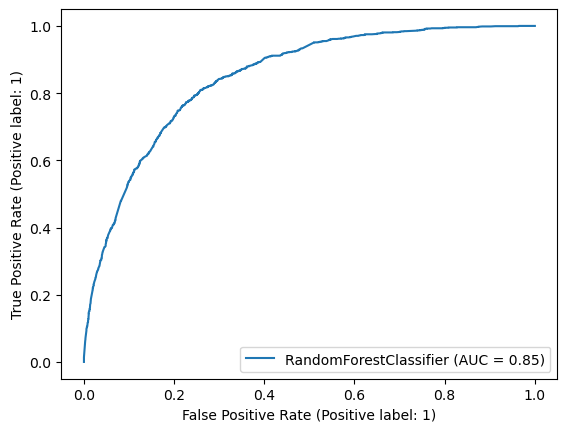

In [505]:
plot_roc_curve(rf, X_train, y_train)
plt.show()

### Hyper-parameter tuning for the Random Forest

In [506]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True)

In [507]:
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10, 25, 50, 100]
}

In [508]:
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [509]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 120 candidates, totalling 480 fits
Wall time: 1min 21s


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='accuracy', verbose=1)

In [510]:
grid_search.best_score_

0.8047555361824943

In [511]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_jobs=-1,
                       oob_score=True, random_state=42)

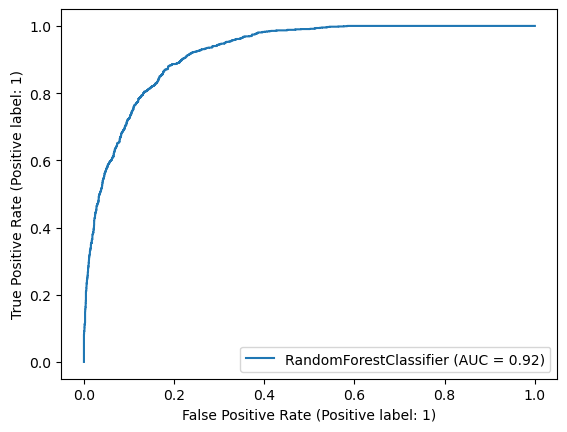

In [512]:
plot_roc_curve(rf_best, X_train, y_train)
plt.show()

In [513]:
rf_best.feature_importances_

array([0.18467568, 0.00428761, 0.01680924, 0.10468866, 0.1391503 ,
       0.01617061, 0.00919805, 0.01009522, 0.0351729 , 0.0500925 ,
       0.00752117, 0.04194471, 0.00788822, 0.01184186, 0.07714897,
       0.01677421, 0.00910346, 0.00906618, 0.06686565, 0.01208793,
       0.0221372 , 0.01153073, 0.01726205, 0.00776034, 0.06110446,
       0.01178177, 0.01092192, 0.00918687, 0.00861561, 0.00911594])

In [514]:
imp_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": rf_best.feature_importances_
})

In [515]:
imp_df.sort_values(by="Imp", ascending=False)

,Varname,Imp
0,tenure,0.184676
4,TotalCharges,0.139150
3,MonthlyCharges,0.104689
14,InternetService_Fiber optic,0.077149
18,OnlineSecurity_No,0.066866
24,TechSupport_No,0.061104
9,Contract_Two year,0.050092
11,PaymentMethod_Electronic check,0.041945
8,Contract_One year,0.035173
20,OnlineBackup_No,0.022137


In [ ]:
rf_best

In [516]:
y_train_pred = rf_best.predict(X_train)
y_test_pred = rf_best.predict(X_test)

In [517]:
# Training

In [518]:
train_final_table = pd.DataFrame()

train_final_table['Churn'] = pd.DataFrame(y_train)
train_final_table['Predicted'] = y_train_pred
train_final_table

,Churn,Predicted
879,0,0
5790,0,0
6498,1,1
880,1,1
2784,1,1
...,...,...
79,0,0
3934,0,0
5964,0,0
6947,0,0


In [519]:
confusion_matrix_table, precision_value, recall_value, specificity_value, FN, accuracy_value = get_evaluation_metrics(train_final_table, 'Churn', 'Predicted', Print=True)

Confusion Matrix: 
 [[3434  201]
 [ 527  760]]
Precision Score:  0.7908428720083247
Recall Score:  0.5905205905205905
Specificity:  0.9447042640990372
False Negative %: 10.707029662738723 (527)
Accuracy:  0.8520926452661519


In [520]:
# Creating metrics list
metric_row = [ 'Random Forest (Best)','Training Data', precision_value, recall_value, specificity_value, FN, accuracy_value]

# Adding metrics list to the dataframe
metrics_df.loc[len(metrics_df)] = metric_row

metrics_df

,Model,Data,Precision,Recall,Specificity,False Negative,Accuracy
0,Logistic (all features),Training Data,0.664492,0.554002,0.900963,574.000000,0.810240
1,Logistic (13 features - 0.5 cutoff),Training Data,0.659026,0.536131,0.901788,597.000000,0.806176
2,Logistic (13 features - 0.3 cutoff),Training Data,0.542051,0.776224,0.767813,288.000000,0.770012
3,Logistic (13 features - 0.30 cutoff),Test Data,0.521793,0.719931,0.748691,163.000000,0.740758
4,Logistic (13 features - 0.43 cutoff),Test Data,0.611765,0.625430,0.848822,218.000000,0.787204
5,Decision Tree (Base),Training Data,0.680338,0.438228,0.927098,14.689151,0.799269
6,Decision Tree (Base),Test Data,0.673522,0.450172,0.916885,15.165877,0.788152
7,Decision Tree (Best),Training Data,0.680934,0.543901,0.909766,11.926046,0.814100
8,Decision Tree (Base),Test Data,0.662420,0.536082,0.895942,12.796209,0.796682
9,Random Fprest (Best),Training Data,0.790843,0.590521,0.944704,10.707030,0.852093


# Hree

In [521]:
test_final_table = pd.DataFrame()

test_final_table['Churn'] = pd.DataFrame(y_test)
test_final_table['Predicted'] = y_test_pred
test_final_table

,Churn,Predicted
942,0,0
3730,1,0
1761,0,0
2283,1,1
1872,0,0
...,...,...
1289,0,0
3508,0,0
6765,0,0
3598,0,1


In [522]:
confusion_matrix_table, precision_value, recall_value, specificity_value, FN, accuracy_value = get_evaluation_metrics(test_final_table, 'Churn', 'Predicted', Print=True)

Confusion Matrix: 
 [[1369  159]
 [ 285  297]]
Precision Score:  0.6513157894736842
Recall Score:  0.5103092783505154
Specificity:  0.8959424083769634
False Negative %: 13.507109004739338 (285)
Accuracy:  0.7895734597156399


In [523]:
# Creating metrics list
metric_row = [ 'RF (Best)','Test Data', precision_value, recall_value, specificity_value, FN, accuracy_value]

# Adding metrics list to the dataframe
metrics_df.loc[len(metrics_df)] = metric_row

metrics_df

,Model,Data,Precision,Recall,Specificity,False Negative,Accuracy
0,Logistic (all features),Training Data,0.664492,0.554002,0.900963,574.000000,0.810240
1,Logistic (13 features - 0.5 cutoff),Training Data,0.659026,0.536131,0.901788,597.000000,0.806176
2,Logistic (13 features - 0.3 cutoff),Training Data,0.542051,0.776224,0.767813,288.000000,0.770012
3,Logistic (13 features - 0.30 cutoff),Test Data,0.521793,0.719931,0.748691,163.000000,0.740758
4,Logistic (13 features - 0.43 cutoff),Test Data,0.611765,0.625430,0.848822,218.000000,0.787204
5,Decision Tree (Base),Training Data,0.680338,0.438228,0.927098,14.689151,0.799269
6,Decision Tree (Base),Test Data,0.673522,0.450172,0.916885,15.165877,0.788152
7,Decision Tree (Best),Training Data,0.680934,0.543901,0.909766,11.926046,0.814100
8,Decision Tree (Base),Test Data,0.662420,0.536082,0.895942,12.796209,0.796682
9,Random Fprest (Best),Training Data,0.790843,0.590521,0.944704,10.707030,0.852093


Now, we need to check whether creating metrics table for DT & RF is relevant or not. Should we remove it?

How to compare Logistic model, DT Model & RF Model